# This ML script would not have been possible without inspiration from, github user ***'wiamsuri'*** and their project ***'cnn-image-classifier-keras'***

In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
# from PIL import ImageFile
import random
from tqdm import tqdm
from keras.preprocessing import image
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from skimage.transform import resize
import os
import pandas as pd

# Load Images From File

In [2]:
image_names = [item.replace('resources/data_for_training_06/', '') for item in sorted(glob("resources/data_for_training_06/*/"))]
number_of_image_categories = len(image_names)
print('%d image categories.' % number_of_image_categories)
print('Three categories:')
print(image_names[:3])

3 image categories.
Three categories:
['brick_10/', 'siding_20/', 'unknown_00/']


In [3]:
def load_dataset(path):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    image_targets = np_utils.to_categorical(np.array(data['target']), number_of_image_categories)
    return image_files, image_targets


image_files, image_targets = load_dataset('resources/data_for_training_06/')

trains_validate_files, test_files, trains_validate_targets, test_targets = \
    train_test_split(image_files, image_targets, test_size=0.2, random_state=42)

train_files, valid_files, train_targets, valid_targets = \
    train_test_split(trains_validate_files, trains_validate_targets, test_size=0.25, random_state=42)

image_names = [item for item in sorted(glob("resources/data_for_training_06/*/"))]

print('%s images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('%d training images.' % len(train_files))
print('%d validation images.' % len(valid_files))
print('%d test images.'% len(test_files))

4105 images.

2463 training images.
821 validation images.
821 test images.


# Define function for preprocessing images

In [4]:
def path_to_tensor(img_path):

    img = image.load_img(img_path, grayscale=False, color_mode="rgb", target_size=(500, 500), interpolation="nearest")
    img_array = image.img_to_array(img)

    return np.expand_dims(img_array, axis=0)

def paths_to_tensor(img_paths):
    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# Preprocess images

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 821/821 [00:10<00:00, 81.16it/s] 


# Build Model

In [6]:
model = Sequential()
# ADJUST FILTER?
model.add(Conv2D(filters=2, kernel_size=2, padding='same',
                 activation='relu', input_shape=(500, 500, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=4, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=12, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax'))


model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 500, 500, 2)       26        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 250, 250, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 4)       36        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 4)       0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 8)       136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 8)         0

# Train the model with training and validating images

In [7]:
epochs = 15

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.image_classifier.hdf5',
                               verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

Epoch 1/15
39/39 [==============================] - ETA: 0s - loss: 0.9926 - accuracy: 0.4807
Epoch 00001: val_loss improved from inf to 0.93744, saving model to saved_models/weights.best.image_classifier.hdf5
39/39 [==============================] - 167s 4s/step - loss: 0.9926 - accuracy: 0.4807 - val_loss: 0.9374 - val_accuracy: 0.5773
Epoch 2/15
39/39 [==============================] - ETA: 0s - loss: 0.9038 - accuracy: 0.5575
Epoch 00002: val_loss improved from 0.93744 to 0.90930, saving model to saved_models/weights.best.image_classifier.hdf5
39/39 [==============================] - 180s 5s/step - loss: 0.9038 - accuracy: 0.5575 - val_loss: 0.9093 - val_accuracy: 0.5152
Epoch 3/15
39/39 [==============================] - ETA: 0s - loss: 0.8574 - accuracy: 0.6102
Epoch 00003: val_loss did not improve from 0.90930
39/39 [==============================] - 208s 5s/step - loss: 0.8574 - accuracy: 0.6102 - val_loss: 0.9729 - val_accuracy: 0.5201
Epoch 4/15
39/39 [=======================

In [8]:
model.load_weights('saved_models/weights.best.image_classifier.hdf5')

predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.5883%


In [9]:
for image in os.listdir('test_imgs'):
    img = plt.imread('test_imgs' + '/' + image)
    resized_image = resize(img, (500,500,3))
    predictions = model.predict(np.array([resized_image]))
#     print(f'{image}:\t {predictions}')
    if image.split("_")[0] == "brick":
        print(image, predictions)
#         print(f'{image}:\t {round(100 * predictions[0][0])}%')

# for image in os.listdir('test_imgs'):
#     img = plt.imread('test_imgs' + '/' + image)
#     resized_image = resize(img, (400,400,3))
#     predictions = model.predict(np.array([resized_image]))
# #     print(f'{image}:\t {predictions}')
#     if image.split("_")[0] == "brick":
# #         print(f'{image}:\t {round(100 * predictions[0][0])}%')

# for image in os.listdir('test_imgs'):
#     img = plt.imread('test_imgs' + '/' + image)
#     resized_image = resize(img, (400,400,3))
#     predictions = model.predict(np.array([resized_image]))
# #     print(f'{image}:\t {predictions}')
#     if image.split("_")[0] == "unknown":
# #         print(f'{image}:\t {round(100 * predictions[0][0])}%')

#['brick_10/', 'siding_20/', 'unknown_00/']

brick_7266.jpg [[0.8882389  0.04149141 0.0702697 ]]
brick_81.jpg [[0.73900557 0.20314707 0.05784738]]
brick_7664.jpg [[0.57833385 0.08972608 0.33194005]]
brick_5902.jpg [[0.63951474 0.16312541 0.19735986]]
brick_5901.jpg [[0.5771083  0.16150549 0.2613862 ]]
brick_62.jpg [[0.65323836 0.13001898 0.21674268]]
brick_7839.jpg [[0.5448561  0.13954513 0.3155988 ]]
brick_6449.jpg [[0.51309335 0.12932195 0.35758477]]


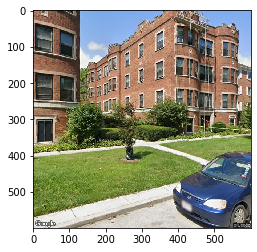

In [10]:
new_image = plt.imread('test_imgs/brick_7266.jpg')
img = plt.imshow(new_image)

In [11]:
#Sort the predictions from least to greatest
list_index = [0, 1, 2]
x = predictions

for i in range(3):
  for j in range(3):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#Show the sorted labels in order
print(list_index)

[0, 2, 1]


In [12]:
## OPTIONAL WRITE HISTORY TO JSON
# with open('trainHistoryDict', 'wb') as file_pi:
#         pickle.dump(history.history, file_pi)

# history = pickle.load(open('/trainHistoryDict', "rb"))

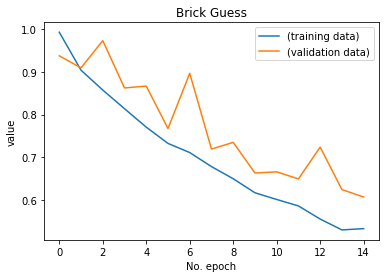

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot history: 
plt.plot(history.history['loss'], label='(training data)')
plt.plot(history.history['val_loss'], label='(validation data)')
plt.title('Brick Guess')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()
plt.savefig('65pct.png')